In [12]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [13]:
def remove_corrs(df):
    
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    corr_index = correlations['1'].value_counts().index
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

In [14]:
def preprocess_data(df):
    
    df.index = pd.to_datetime(df.index)
    
    X = df.shift(1).dropna()
    
    X_data = remove_corrs(X)
    
    y = df['day_direction'].iloc[1:]
    
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)
    print(train_num, test_num)
    
    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [15]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy', n_jobs = -1, error_score = 0)
    gs.fit(X_train, y_train)
        
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)
    
    results = ['random forest', train_score, cv_results, test_score]
    
    return results

In [16]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)

    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)
    
    results = ['decision tree', train_score, cv_results, test_score]
    
    return results

In [17]:
def random_forest(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_estimators': [75,90,100,110,115,125,150,500],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Random Forest model for GridSearch
    grid_rf = RandomForestClassifier()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')

    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);

    results = ['random forest', train_score, cv_results, test_score]
    
    return results

In [18]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.01,.05,.1,.5,1],
    'max_depth': [4],
    'min_child_weight': [3],
    'subsample': [1],
    'n_estimators': [100,500]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(verbosity=0, random_state=42)
    #xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')

    
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);
    
    results = ['xgboost', train_score, cv_results, test_score]
    
    return results

In [19]:
def Linear_SVC(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    }
    
    # Instantiate & fit XGClassifier
    svc = LinearSVC(random_state=42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=svc, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train Mean Accuracy Score: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results}')
    print(f'Test Mean Accuracy Score: {test_score}')
    
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);
    
    results = ['SVC', train_score, cv_results, test_score]
    
    return results

In [27]:
files = [f for f in listdir('.\FormattedData')]

companies = []
for i in files:
    company = i.split('.')[0]
    companies.append(company)
    
test_companies = np.random.choice(companies, 8, replace = False)

1798 450
Train Mean Accuracy: 0.5378197997775306
Mean Cross-Val Accuracy: 0.5378195605075827
Test Mean Accuracy: 0.5066666666666667
Train Mean Accuracy: 0.5472747497219133
Mean Cross-Val Accuracy: 0.458857938718663
Test Mean Accuracy: 0.52
Train Mean Accuracy: 1.0
Mean Cross-Val Accuracy: 0.4610755184153513
Test Mean Accuracy: 0.5155555555555555
Train Mean Accuracy: 1.0
Mean Cross-Val Score: 0.46831940575673164
Test Mean Accuracy: 0.5022222222222222
Train Mean Accuracy Score: 0.5378197997775306
Mean Cross-Val Score: 0.5078195605075828
Test Mean Accuracy Score: 0.5066666666666667
1798 450
Train Mean Accuracy: 0.5333704115684094
Mean Cross-Val Accuracy: 0.5333704735376045
Test Mean Accuracy: 0.5755555555555556
Train Mean Accuracy: 0.5339265850945495
Mean Cross-Val Accuracy: 0.5066976168368926
Test Mean Accuracy: 0.5755555555555556
Train Mean Accuracy: 1.0
Mean Cross-Val Accuracy: 0.43884710615908384
Test Mean Accuracy: 0.4288888888888889
Train Mean Accuracy: 0.6384872080088988
Mean Cross

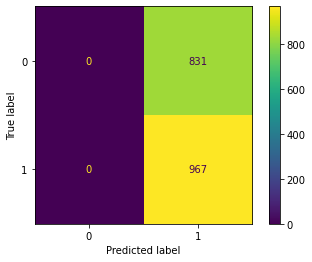

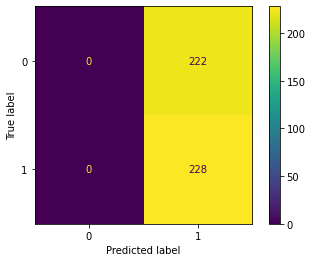

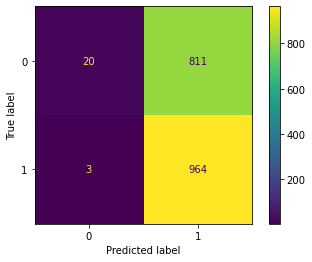

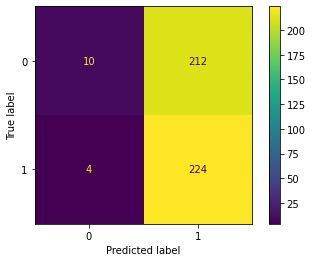

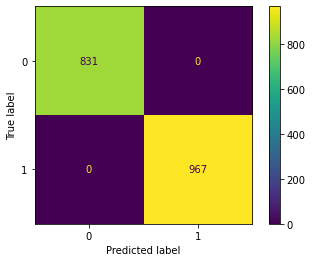

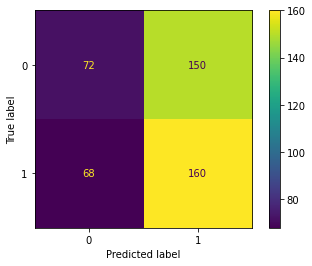

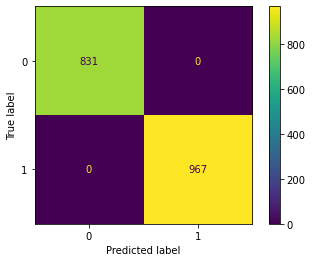

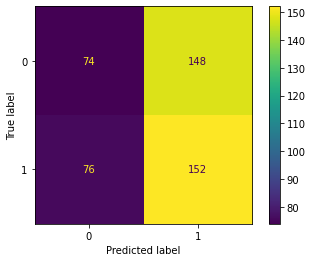

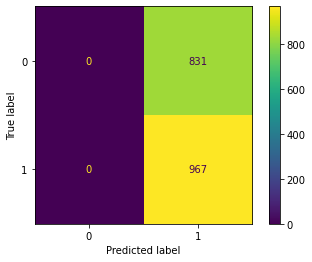

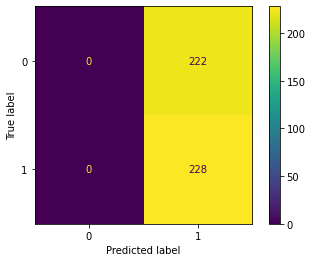

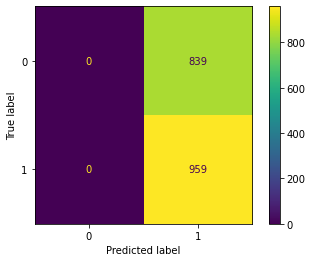

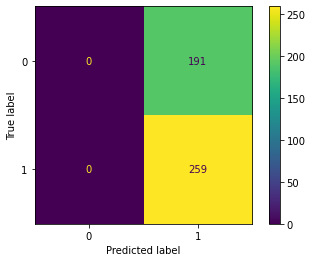

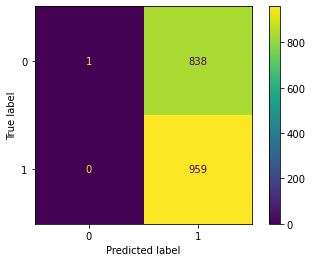

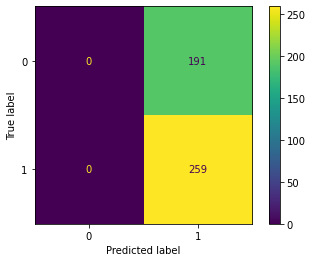

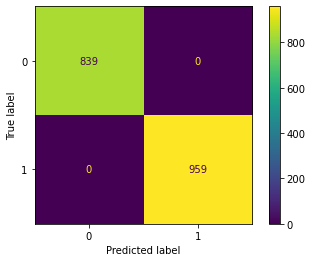

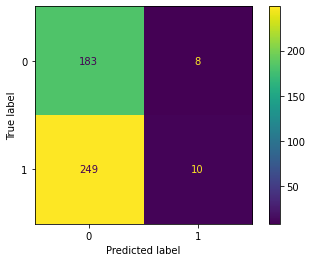

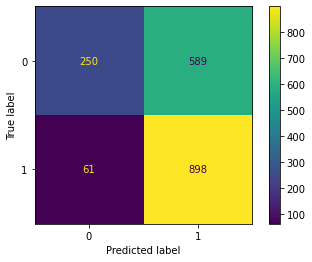

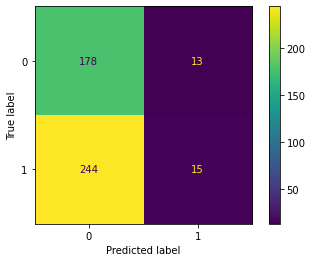

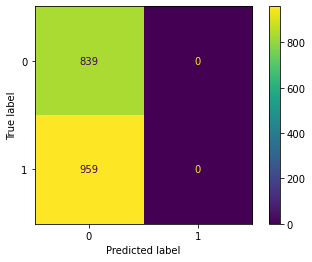

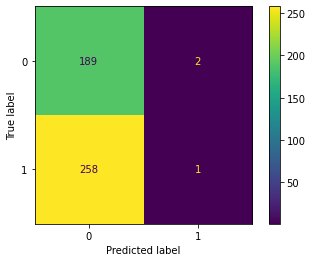

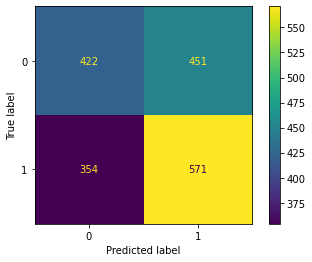

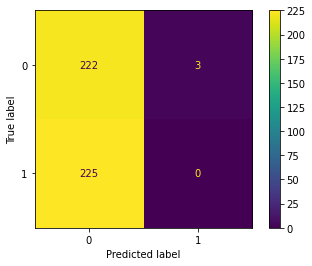

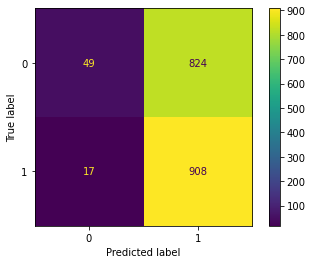

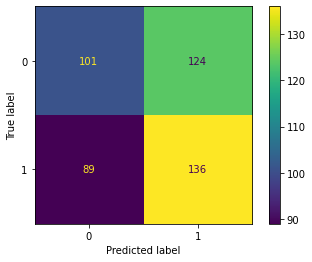

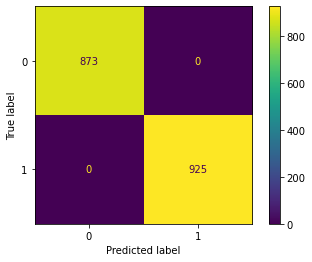

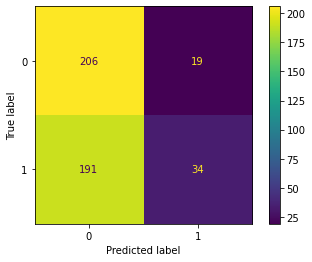

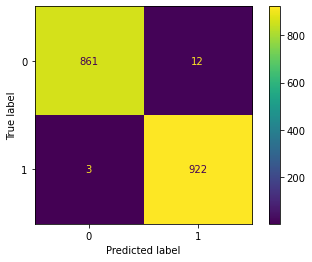

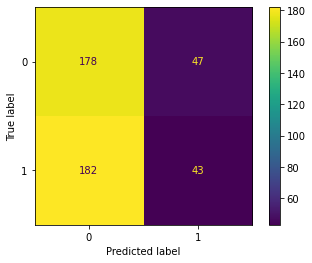

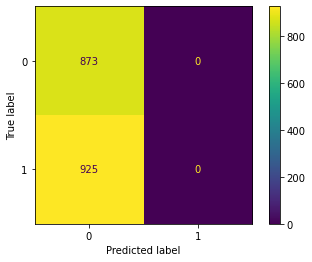

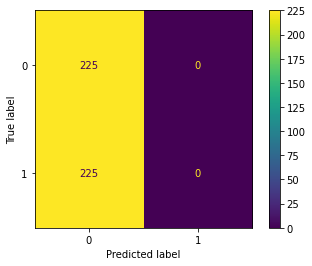

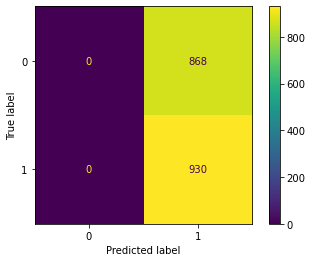

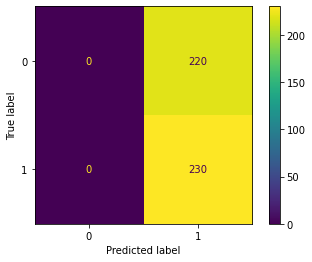

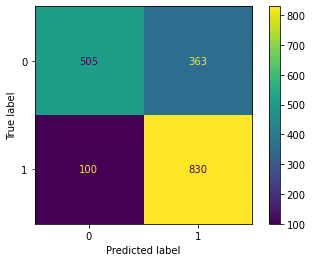

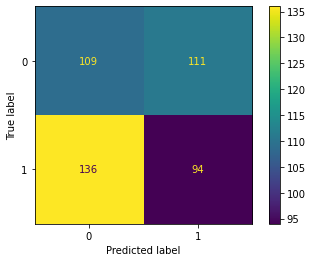

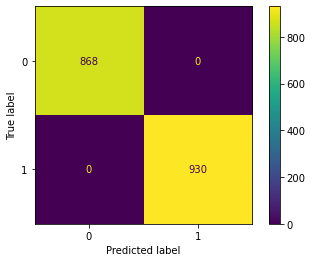

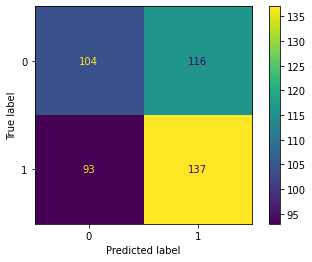

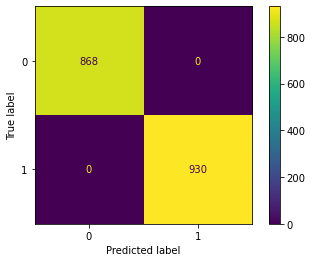

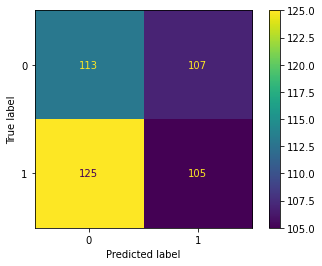

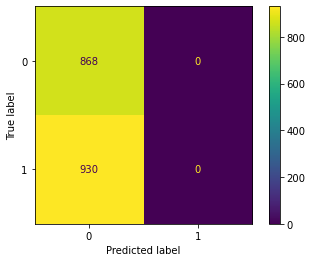

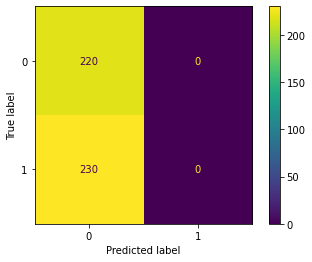

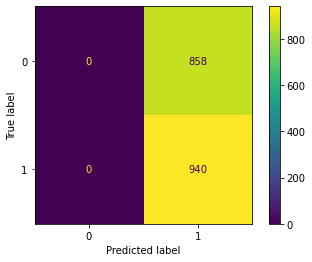

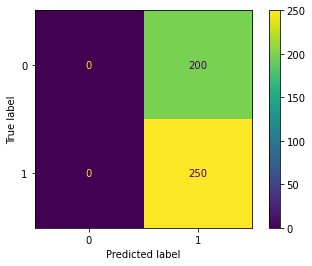

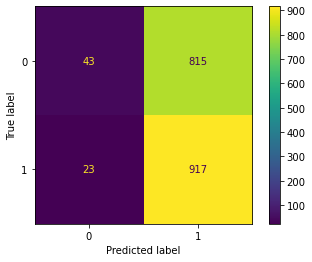

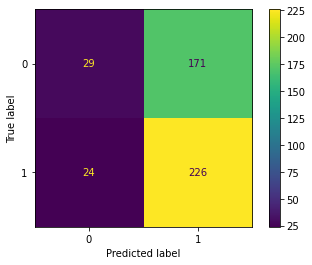

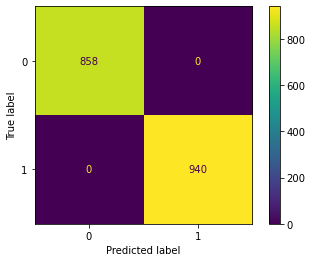

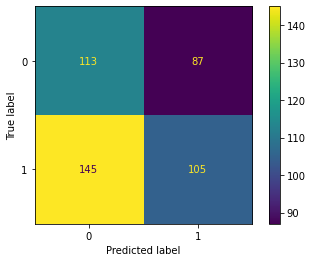

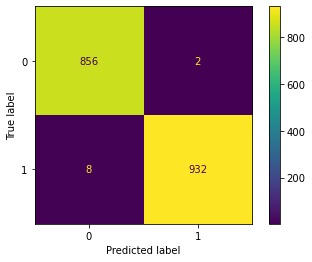

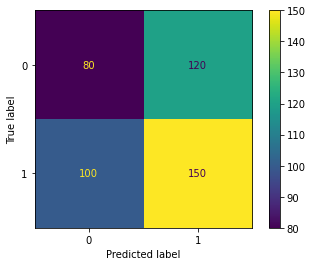

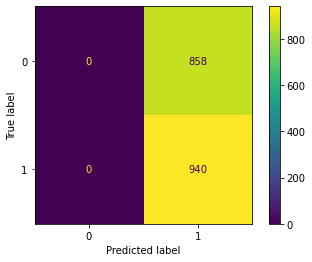

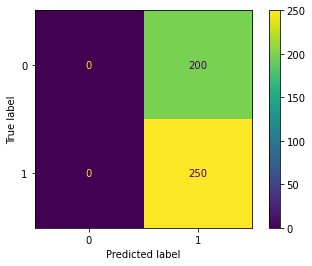

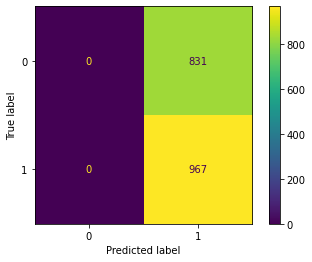

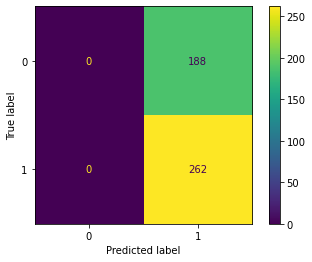

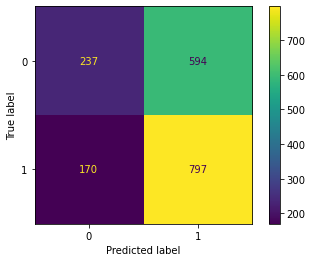

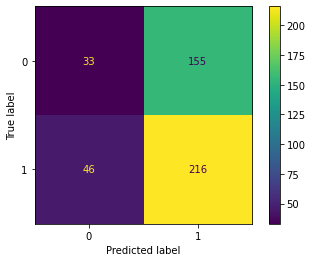

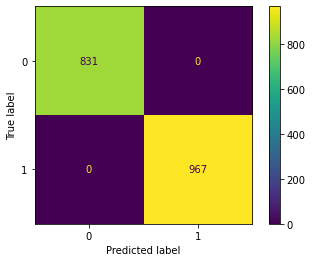

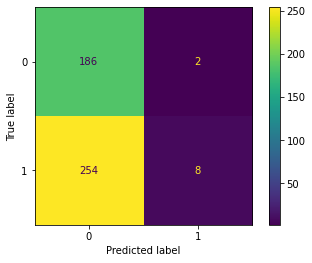

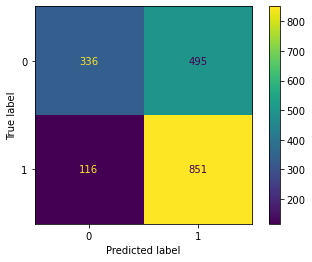

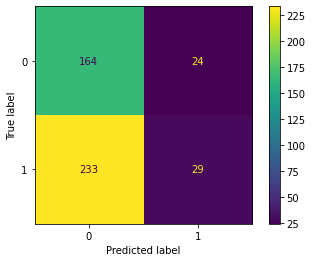

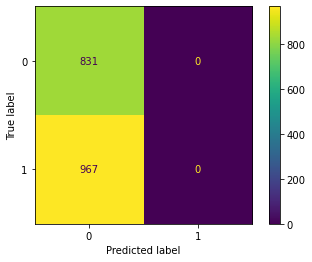

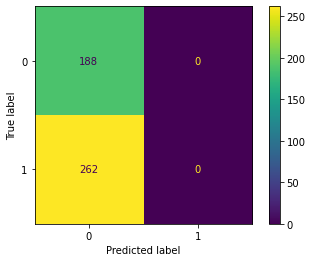

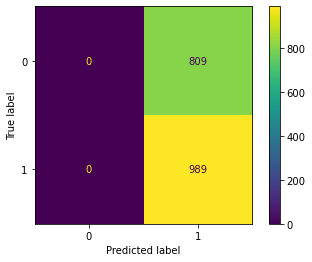

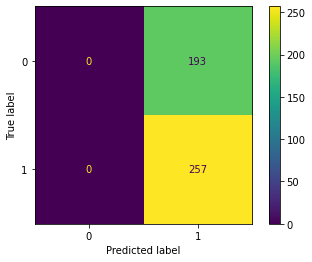

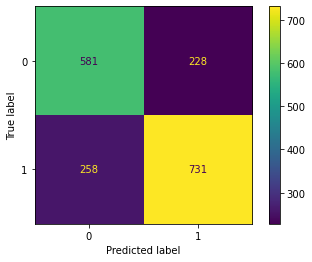

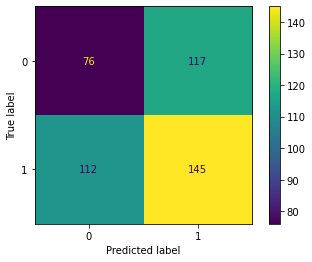

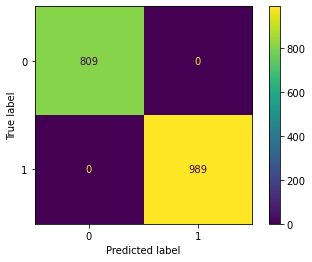

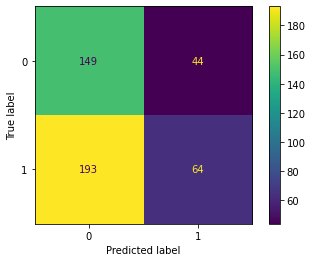

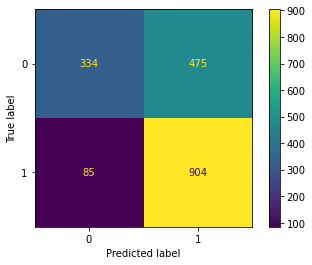

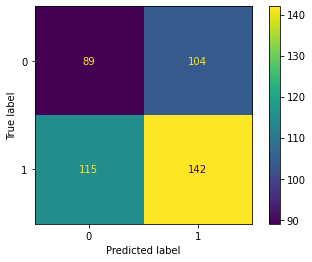

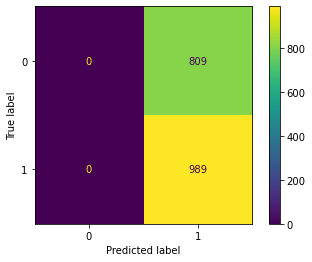

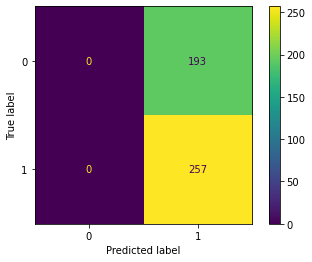

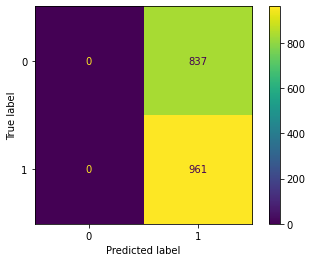

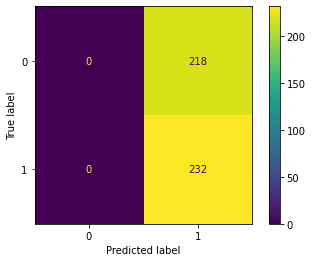

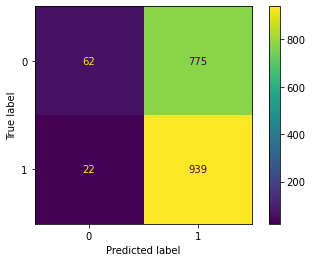

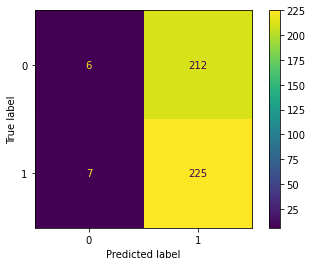

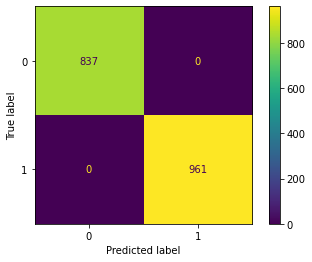

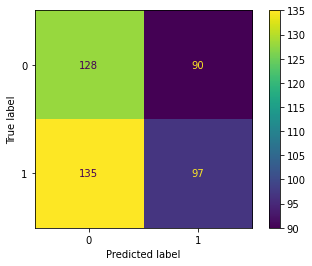

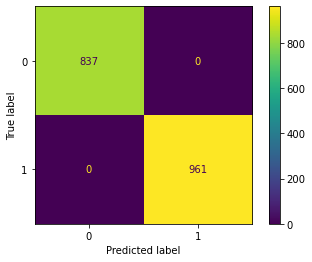

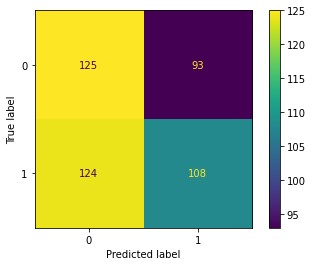

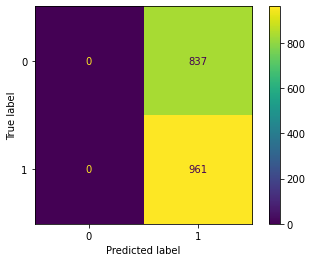

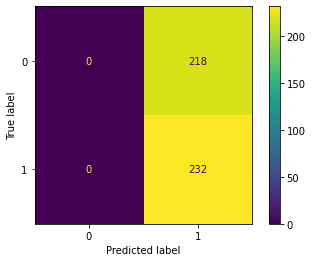

In [28]:
results2 = []

for c in test_companies:
    csv_for_df = f'FormattedData/{c}.csv'
    df = pd.read_csv(csv_for_df, index_col = 0)
    X_train, X_test, y_train, y_test = preprocess_data(df)
    logreg_results = logreg(X_train, X_test, y_train, y_test)
    dtree_results = dtree(X_train, X_test, y_train, y_test)
    randomforest_results = random_forest(X_train, X_test, y_train, y_test)
    xgboost_results = xgboost(X_train, X_test, y_train, y_test)
    svc_results = Linear_SVC(X_train, X_test, y_train, y_test)
    c_results = pd.DataFrame([logreg_results, dtree_results, randomforest_results, xgboost_results, svc_results],
            columns = ['Model Type', 'Train Accuracy', 'Cross Val Accuracy','Test Accuracy'])
    c_results['company'] = c.split('_')[0]
    results2.append(c_results)

In [26]:
best_results = pd.concat(results)
best_results2 = pd.concat(results2)
best_results.sort_values('Test Accuracy', ascending = False)

,Model Type,Train Accuracy,Cross Val Accuracy,Test Accuracy,company
1,decision tree,0.533927,0.498880,0.566667,DXCM
1,decision tree,0.730256,0.517241,0.555556,GWW
0,random forest,0.522803,0.516676,0.555556,DXCM
4,SVC,0.522803,0.509454,0.555556,DXCM
3,xgboost,0.993326,0.517798,0.524444,GWW
3,xgboost,0.735261,0.514994,0.520000,FLT
1,decision tree,0.567297,0.504983,0.517778,FLT
2,random forest,1.000000,0.508940,0.511111,GWW
3,xgboost,0.994438,0.494960,0.511111,DXCM
2,random forest,1.000000,0.495545,0.502222,FLT


In [36]:
best_results.groupby('Model Type').mean().sort_values('Test Accuracy', ascending = False)

,Train Accuracy,Cross Val Accuracy,Test Accuracy
Model Type,,,
decision tree,0.598443,0.503084,0.530707
random forest,0.768708,0.507559,0.510909
SVC,0.500809,0.500810,0.498990
xgboost,0.881484,0.495291,0.493939
